## KDE(Kernel Density Estimation)의 이해

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')
sns.set(color_codes=True)

[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985   0.14404357  1.45427351
  0.76103773  0.12167502  0.44386323  0.33367433  1.49407907 -0.20515826
  0.3130677  -0.85409574 -2.55298982  0.6536186   0.8644362  -0.74216502
  2.26975462 -1.45436567  0.04575852 -0.18718385  1.53277921  1.46935877]


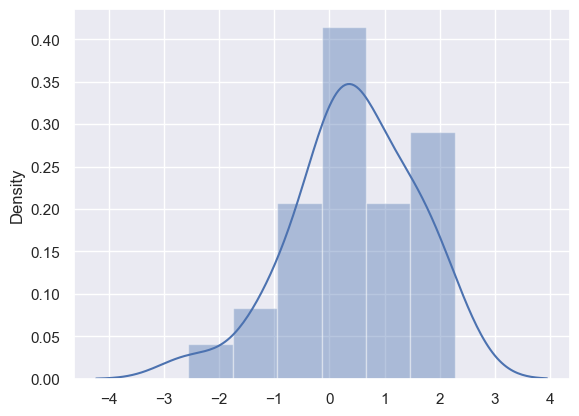

In [14]:
np.random.seed(0)
x = np.random.normal(0, 1, size=30)
print(x)
sns.distplot(x)
plt.show()

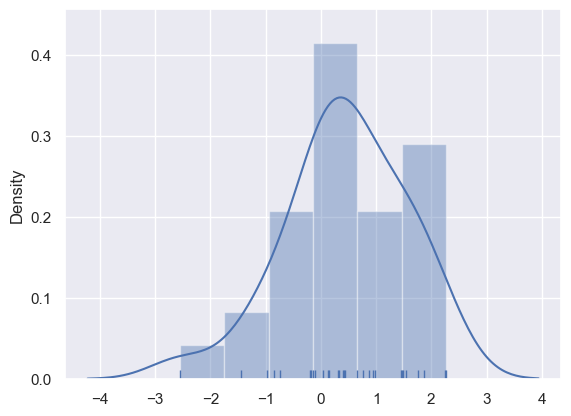

In [17]:
sns.distplot(x, rug=True)
plt.show()

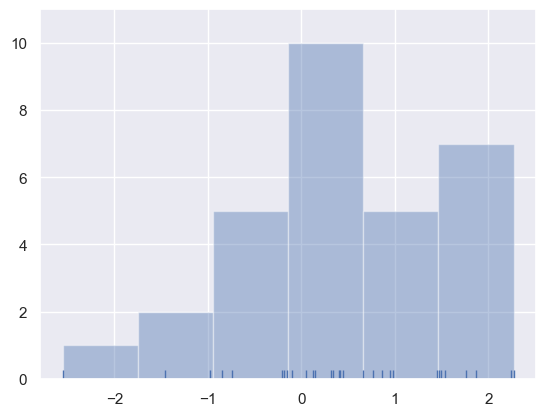

In [20]:
sns.distplot(x, kde=False, rug=True)
plt.show()

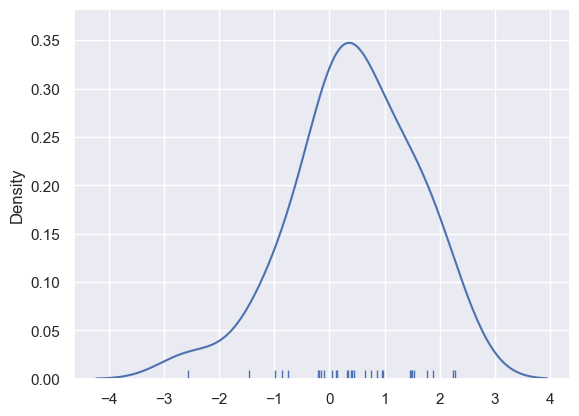

In [22]:
sns.distplot(x, hist=False, rug=True)
plt.show()

### 개별 관측 데이터에 대해 가우시안 커널 함수 적용

<Axes: >

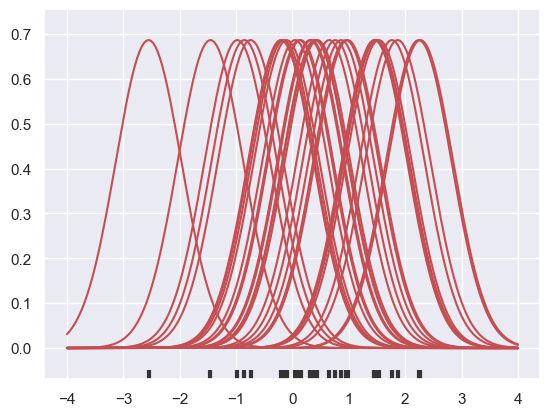

In [26]:
from scipy import stats

bandwidth = 1.06 * x.std() * x.size ** (-1 / 5.)
support = np.linspace(-4, 4, 200)

kernels = []
for x_i in x:
    kernel = stats.norm(x_i, bandwidth).pdf(support)
    kernels.append(kernel)
    plt.plot(support, kernel, color="r")

sns.rugplot(x, color=".2", linewidth=3)

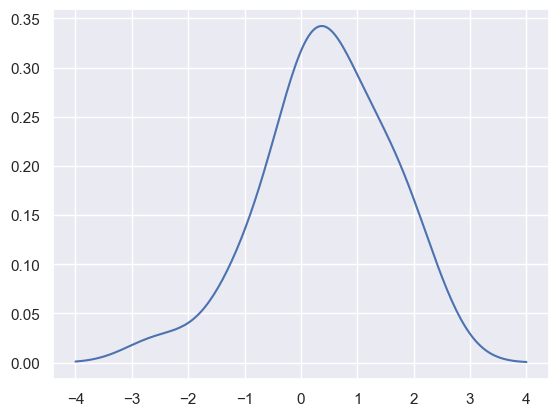

In [27]:
from scipy.integrate import trapz
density = np.sum(kernels, axis=0)
density /= trapz(density, support)
plt.plot(support, density)

### seaborn에서는 kdeplot()으로 kde 곡선을 바로 구할 수 있음

<Axes: ylabel='Density'>

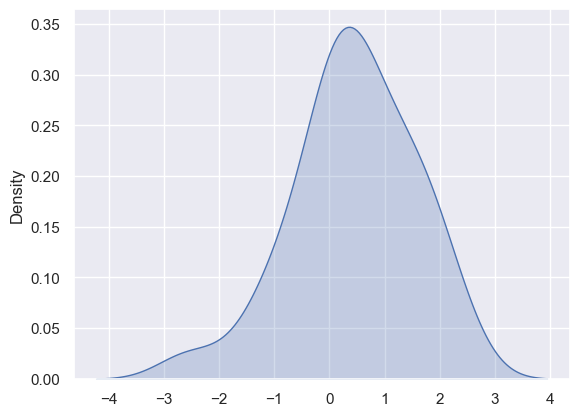

In [28]:
sns.kdeplot(x, shade=True)

### Bandwidth에 따른 KDE 변화

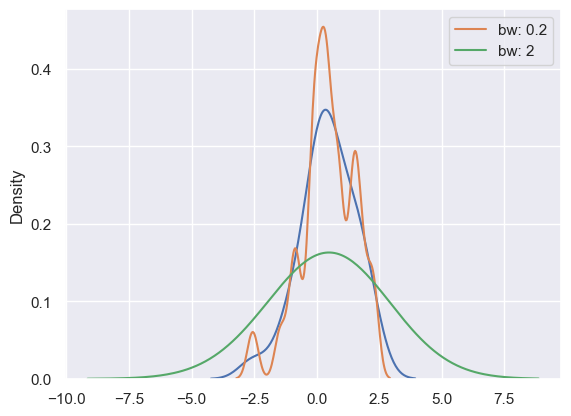

In [39]:
sns.kdeplot(x)
sns.kdeplot(x, bw=.2, label="bw: 0.2")
sns.kdeplot(x, bw=2, label="bw: 2")
plt.legend()

- 작은 *bandwidth* 값: 좁고 뾰족한 KDE를 가짐. **과적합** 되기 쉬움. 많은 수의 군집 중심점을 가짐
- 큰 *bandwidth* 값: 과도하게 평활화된 KDE를 가짐. **과소적합** 되기 쉬움. 적은 수의 군집 중심점을 가짐

## 사이킷런을 이용한 Mean Shift
: K-평균과 유사하게, 군집의 중심을 지속적으로 움직이면서 군집화를 수행함

: 그러나, K-평균이 중심에 소속된 데이터의 평균 거리 중심으로 이동하는데 반해,

: 평균 이동은 데이터가 모여있는 밀도가 가장 높은 곳으로 이동시키면서 군집화하는 방법

: 평균 이동의 장점
- 이상치의 영향력도 크지 않으며, 미리 군집의 개수를 정하지 않아도 된다.

: 평균 이동의 단점
- 수행 시간이 오래 걸리고, bandwidth의 크기에 따른 군집화 영향도가 크다.

In [40]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.8, random_state=0)

meanshift = MeanShift(bandwidth=0.9)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5 6 7]


In [42]:
# 커널함수의 bandwidth 크기를 1로 약간 증가시킨 후 Mean Shift 군집화 다시 수행
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


⇒ Mean Shift는 Bandwidth가 클수록 적은 수의 클러스터링 중심점을, Bandwidth가 작을수록 많은 수의 클러스터링 중심점을 가지게 됨. 또한, Mean Shift는 군집의 개수를 지정하지 않으며, 오직 Bandwidth의 크기에 따라 군집화를 수행

In [43]:
# 최적의 bandwidth계산을 위해 사이킷런은 estimate_bandwidth()함수를 제공
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X, quantile=0.25)
print("최적 bandwidth 값:", round(bandwidth, 3))

최적 bandwidth 값: 1.689


In [45]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

best_bandwidth = estimate_bandwidth(X, quantile=0.25)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


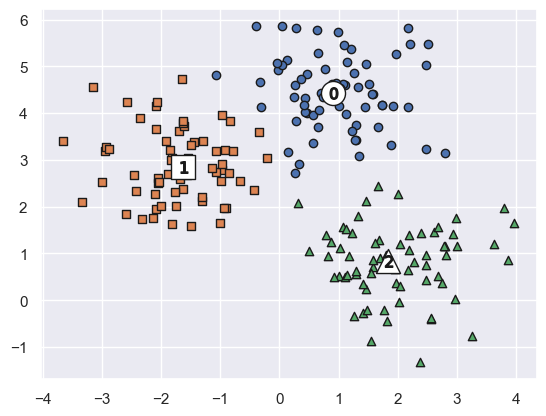

In [58]:
import matplotlib.pyplot as plt

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers = ['o', 's', '^']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]
    
    # 군집별로 다른 marker로 scatter plot 적용
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])

    # 군집별 중심 시각화
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=300, color='white', edgecolors='k', marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolors='k', marker='$%d$' % label)
    
plt.show()

In [59]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       2                  67
2       1                  65
        2                   1
Name: count, dtype: int64
